In [100]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from joblib import dump as jdump
from joblib import load as jload
import time
import cv2
import random

In [101]:
SUBJECT = 1
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
R_TRAIN = 0.9
n_epochs = 200
trainable_layers = 2

In [102]:
with open(f"/content/drive/MyDrive/Projects/EyeTracker/subjects/{SUBJECT}/eyes_data_gray.pickle", "rb") as f1:
    x1_load0 = pickle.load(f1)
with open(f"/content/drive/MyDrive/Projects/EyeTracker/subjects/{SUBJECT}/vector_inputs.pickle", "rb") as f2:
    x2_load0 = pickle.load(f2)
with open(f"/content/drive/MyDrive/Projects/EyeTracker/subjects/{SUBJECT}/red_point_locations.pickle", "rb") as f3:
    y_load0 = pickle.load(f3)


In [103]:
n_img_per_point0 = 50
n_img_per_point1 = 400
x1_load_l = []
x2_load_l = []
y_load_l = []
for i in range(35):
  for j in range(n_img_per_point0):
    x1_load_l.append(x1_load0[i * n_img_per_point1 + j])
    x2_load_l.append(x2_load0[i * n_img_per_point1 + j])
    y_load_l.append(y_load0[i * n_img_per_point1 + j])

x1_load = np.array(x1_load_l)
x2_load = np.array(x2_load_l)
y_load = np.array(y_load_l)

In [104]:
print(x1_load.shape, x2_load.shape, y_load.shape)

(1750, 48, 44, 1) (1750, 10) (1750, 2)


In [105]:
n_samples, frame_height, frame_width = x1_load.shape[:-1]
n_samples = x1_load.shape[0]
print(n_samples, frame_height, frame_width)

1750 48 44


[3.12780043e+00 1.95465441e-01 7.02841288e-02 2.56531911e+00
 5.81316547e+00 7.82036158e+01 4.92021710e-01 4.69297975e-01
 5.04254818e-01 4.81658041e-01]
[2396.  474.]


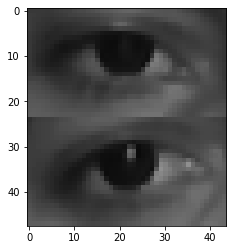

In [106]:
SAMPLE_NUMBER = 1
print(x2_load[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
# plt.imshow(x1_prime_load[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)), cmap="gray", vmin=0, vmax=255)
plt.show()

In [107]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

In [108]:
x1_scaler = 255
x1 = x1_load / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers = [x1_scaler, x2_scaler, y_scalers]
jdump(scalers, f"/content/drive/MyDrive/Projects/EyeTracker/subjects/{SUBJECT}/scalers.bin")

['/content/drive/MyDrive/Projects/EyeTracker/subjects/1/scalers.bin']

In [109]:
y1 = y[:, 0]
y2 = y[:, 1]

In [110]:
x1_shfl, x2_shfl, y1_shfl, y2_shfl = shuffle(x1, x2, y1, y2)

n_train = int(R_TRAIN * n_samples)
x1_train, x2_train = x1_shfl[:n_train], x2_shfl[:n_train]
x1_test, x2_test = x1_shfl[n_train:], x2_shfl[n_train:]
y1_train, y2_train = y1_shfl[:n_train], y2_shfl[:n_train]
y1_test, y2_test = y1_shfl[n_train:], y2_shfl[n_train:]

In [111]:
print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape,
      x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(1575, 48, 44, 1) (175, 48, 44, 1) (1575,) (175,) (1575, 7) (175, 7) (1575,) (175,)


In [112]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]
y_train_list = [y1_train, y2_train]
y_test_list = [y1_test, y2_test]

In [113]:
model = load_model("/content/drive/MyDrive/Projects/EyeTracker/subjects/model.model")

In [114]:
for layer in model.layers[:-trainable_layers]:
  layer.trainable = False
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa7aec86b10> False
<keras.layers.convolutional.Conv2D object at 0x7fa7a46a0950> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa7aeca4f50> False
<keras.layers.convolutional.Conv2D object at 0x7fa7aac8a610> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa7aac8a790> False
<keras.layers.convolutional.Conv2D object at 0x7fa7aac9f750> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa7aac9f150> False
<keras.layers.core.Flatten object at 0x7fa7aac8ef10> False
<keras.layers.core.Dense object at 0x7fa7aac8c410> False
<keras.engine.input_layer.InputLayer object at 0x7fa7aaaf5dd0> False
<keras.layers.merge.Concatenate object at 0x7fa7aac87990> False
<keras.layers.core.Dense object at 0x7fa7aac94250> False
<keras.layers.core.Dense object at 0x7fa7aab28290> False
<keras.layers.core.Dense object at 0x7fa7aac84690> False
<keras.layers.core.Dense object at 0x7fa7aac7e150> False
<keras.layers.core.Dense object at 0x7fa7aaca7a90> F

In [115]:
cb1 = EarlyStopping(patience=16, verbose=1, restore_best_weights=True)

In [116]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 48, 44, 16)   416         input_33[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 24, 22, 16)   0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 24, 22, 32)   12832       max_pooling2d_48[0][0]           
___________________________________________________________________________________________

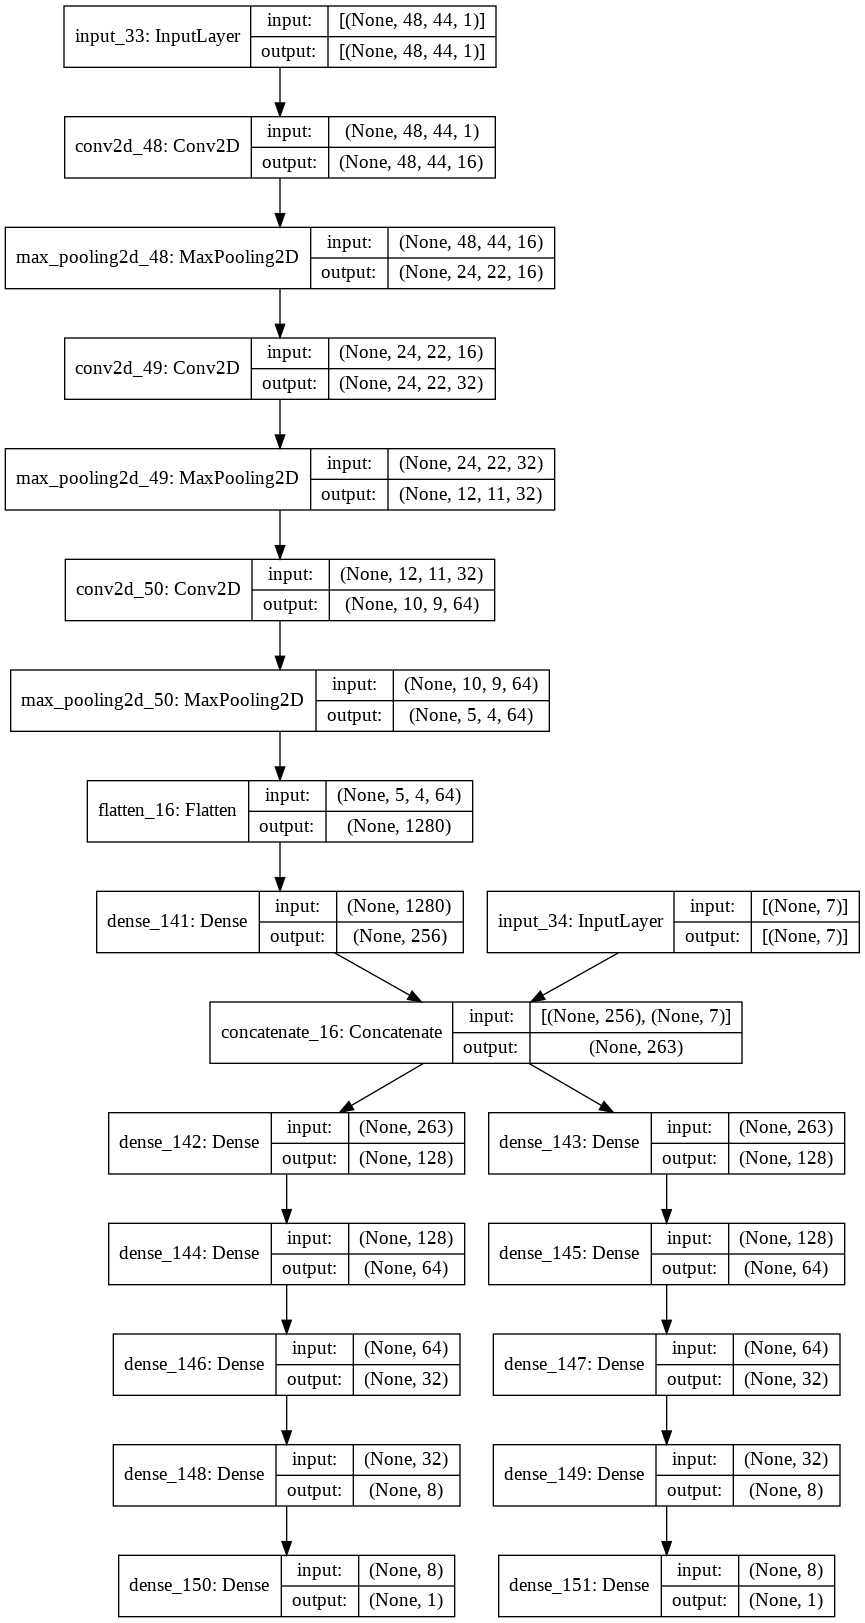

In [165]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [118]:
results = model.fit(x_train_list,
                    y_train_list,
                    validation_data=(x_test_list, y_test_list),
                    epochs=n_epochs,
                    callbacks=[cb1])

Epoch 1/200
50/50 [==============================] - 6s 110ms/step - loss: 0.3058 - dense_150_loss: 0.1106 - dense_151_loss: 0.1952 - val_loss: 0.2762 - val_dense_150_loss: 0.0890 - val_dense_151_loss: 0.1872
Epoch 2/200
50/50 [==============================] - 5s 104ms/step - loss: 0.2586 - dense_150_loss: 0.0914 - dense_151_loss: 0.1672 - val_loss: 0.2566 - val_dense_150_loss: 0.0863 - val_dense_151_loss: 0.1703
Epoch 3/200
50/50 [==============================] - 5s 105ms/step - loss: 0.2426 - dense_150_loss: 0.0854 - dense_151_loss: 0.1572 - val_loss: 0.2397 - val_dense_150_loss: 0.0827 - val_dense_151_loss: 0.1569
Epoch 4/200
50/50 [==============================] - 5s 104ms/step - loss: 0.2208 - dense_150_loss: 0.0806 - dense_151_loss: 0.1402 - val_loss: 0.2307 - val_dense_150_loss: 0.0768 - val_dense_151_loss: 0.1539
Epoch 5/200
50/50 [==============================] - 5s 104ms/step - loss: 0.2089 - dense_150_loss: 0.0778 - dense_151_loss: 0.1311 - val_loss: 0.2321 - val_dense_1

In [119]:
yhat_train_list = model.predict(x_train_list)
yhat_test_list = model.predict(x_test_list)

Train
[1797    0]
[1760    0]
Test
[2396  316]
[2355  318]


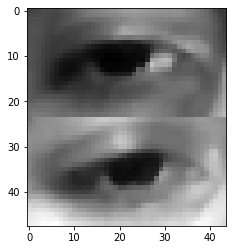

In [164]:
y_train = np.array(y_train_list).reshape((n_train, 2))
yhat_train = np.array(yhat_train_list).reshape((n_train, 2))
y_test = np.array(y_test_list).reshape((n_samples - n_train, 2))
yhat_test = np.array(yhat_test_list).reshape((n_samples - n_train, 2))

NUM = 39
print("Train")
sample_train = (y_train[NUM] * y_scalers).astype(np.uint32)
yhat_train[NUM][yhat_train[NUM] < 0] = 0
sample_train_hat = (yhat_train[NUM] * y_scalers).astype(np.uint32)
print(sample_train)
print(sample_train_hat)

print("Test")
sample_test = (y_test[NUM] * y_scalers).astype(np.uint32)
yhat_test[NUM][yhat_test[NUM] < 0] = 0
sample_test_hat = (yhat_test[NUM] * y_scalers).astype(np.uint32)
print(sample_test)
print(sample_test_hat)
plt.imshow((x1_test[NUM] * 255).astype(np.uint8).reshape((frame_height, frame_width)), cmap="gray")

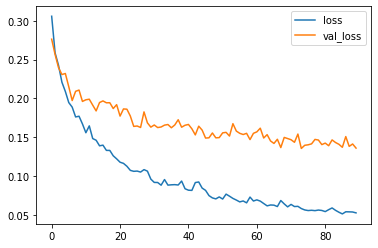

In [121]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

In [122]:
model.save(f"/content/drive/MyDrive/Projects/EyeTracker/subjects/{SUBJECT}/model.model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/subjects/1/model.model/assets
